# Autoencoders

* Autoencoders are unsupervised learning models used to learn representations.

* It is composed by two parts: the encoder and the decoder.

* The encoder is responsible for creating a representation of the original input (code, feature embedding) and the decoder is responsible for trying to recreate the original input from this code. Both encoder and decoder can be built from dense layers.

* The decoder output is not the same as the original input as it was transformed by the encoder and not all the information from it is necessarily present in the code. 

* Loss function: as the loss is computed comparing the input to the decoder output, regression related loss functions are used to train the autoencoder. We can use, for example, the mean squared error.

* After training the autoencoder, it is possible to use the representation (code) for a series of applications. It can be used for indexing data, datasearch in large datasets, and classification useing other ML method.

## Undercomplete autoencoders

* An undercomplete autoencoder's encoder obtains representations that have a reduced dimensionality when compared to the input. They can be used to learn a dimensionality reduction.

* A dense autoencoder with a single encoder/decoder layer has mathematical relation to the PCA method: if the data manifold is linear, the autoencoder tends to converge to a projection of the $m$ principal components of the data.

* Hence, this autoencoder makes a compression of the input, with information loss and the code related layer is called "bottloneck".

* The autoencoder learns to recreate, to its best capabilities, the original inputs. So it is trained to learn patterns on the code that relate to a certain feature in the original input.

* If the autoencoder is trained to recreate images of numbers from 0 to 9, for example, and then is feeded with images of clothes, for example, the output will try to find patterns that ressembles a number on the clothing image. Hence, ir recreates clothes images in ressemblance to numbers.

* Deep undercomplete autoencoders: they can have other types of layers like convolutioinal layers and pooling layers. The code layer is ini most cases a fully conected (dense) layer to allow the projection of the data.

## Overcomplete autoencoders

* Intermediary layer (code layer) with bigger or equal dimensionality than the input.

* A simple implementation would learn to "copy" the input, as the code layer has this capacity. Hence, it is necessary to restrain this space.

* To prevent this, we can use regularization or dropout techiniques.

## Denoising autoencoders

* This type of autoencoder, that can be under or overcomplete, is trainet  to remove noise from an input. The input of this neural network corresponds to the original input with some noise added and the loss function is calculated between the final output and the original input.

* This architecture allows the neural network to learn to remove noise from the original input.

* This noise can be introduced by adding some noise (like a gaussian noise) or remove some points (replace by zero) on the original input.

### Autoencoder example in pytorch

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [2]:
tensor_transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data',
                         train=True,
                         download=True,
                         transform=tensor_transform)

loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=32,
                                     shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # 784 dim -> 128 dim
            nn.ReLU(),
            nn.Linear(128, 32), # 128 dim -> 32 dim
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [9]:
ae = Autoencoder()
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=.002, weight_decay=1e-7)

In [11]:
epochs = 20
outputs = []
losses = []

for epoch in range(epochs):
    print(f'{epoch} ', end='')

    for(image, _) in loader:
        image = image.reshape(-1, 28*28)

        reconstructed = ae(image)

        loss = loss_fn(reconstructed, image)

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss)

    outputs.append((epoch, image, reconstructed))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [12]:
# transforming the losses from a tensor to a list
losses_val = [l.item() for l in losses]

In [13]:
len(losses_val)

37500

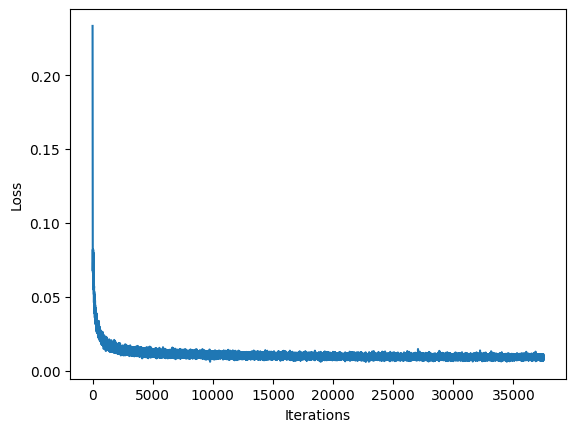

In [14]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses_val)

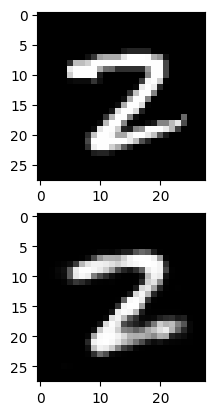

In [15]:
for i, item in enumerate(image):
    item = item.reshape(-1, 28, 28)
    plt.subplot(211)
    plt.imshow(item[0], cmap='gray')

for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    plt.subplot(212)
    plt.imshow(item[0].detach().numpy(), cmap='gray')

We can use the trained encoder to obtain features from the original image (code)

In [16]:
features_imgs = ae.encoder(image)

In [17]:
features_imgs[0].detach().numpy()

array([ 9.956995 ,  0.       ,  5.7709174,  8.044283 ,  0.       ,
        3.2850966,  0.       ,  8.635914 ,  0.       ,  5.8898115,
        7.1035056, 10.69808  ,  8.894035 ,  0.       ,  5.76381  ,
        7.0935125,  1.217407 ,  8.192185 , 11.315899 , 10.180176 ,
        3.2130694,  0.       ,  9.009417 ,  4.1275086,  7.7044225,
        0.       ,  6.8154235,  0.       ,  0.       ,  0.       ,
        0.       ,  4.509123 ], dtype=float32)